In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import gcsfs
from google.colab import auth
from google.cloud import storage
import google.auth
import os
import io
import numpy as np
from matplotlib import pyplot as plt
import sys

In [3]:
# Configuration
from google.colab import auth
auth.authenticate_user()

credentials, project = google.auth.default()
gcs = gcsfs.GCSFileSystem(project=project, token=credentials)

print("GCS FileSystem initialized.")


GCS FileSystem initialized.


In [4]:
# show one sample of each image

GCS_PATHS_TO_PREVIEW = [
    ("Celeb-real", "gs://dlcv_preprocess_pic/Celeb-real/"),
    ("YouTube-real", "gs://dlcv_preprocess_pic/YouTube-real/"),
    ("Celeb-synthesis", "gs://dlcv_preprocess_pic/Celeb-synthesis/")
]

def preview_gcs_images(path_list, gcs_fs):
    """
    Fetches and displays one sample image from each GCS path.
    """
    # Set up the plot
    num_paths = len(path_list)
    plt.figure(figsize=(15, 5))

    for i, (name, gcs_path) in enumerate(path_list):
        # Create a subplot for each image
        ax = plt.subplot(1, num_paths, i + 1)

        # Find all files in the directory
        # We add a wildcard '*' to match all files
        patterns_to_check = ["*.png", "*.jpg", "*.jpeg"]
        file_list = []
        for ext in patterns_to_check:
            file_list.extend(gcs_fs.glob(os.path.join(gcs_path, "**", ext)))

        # Get the first file found
        sample_file_path = file_list[0]

        # Open the file from GCS as bytes
        with gcs_fs.open(sample_file_path, 'rb') as f:
            img_bytes = f.read()
            image = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Display the image
        ax.imshow(image)
        ax.set_title(f"Class: {name}\n{os.path.basename(sample_file_path)}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

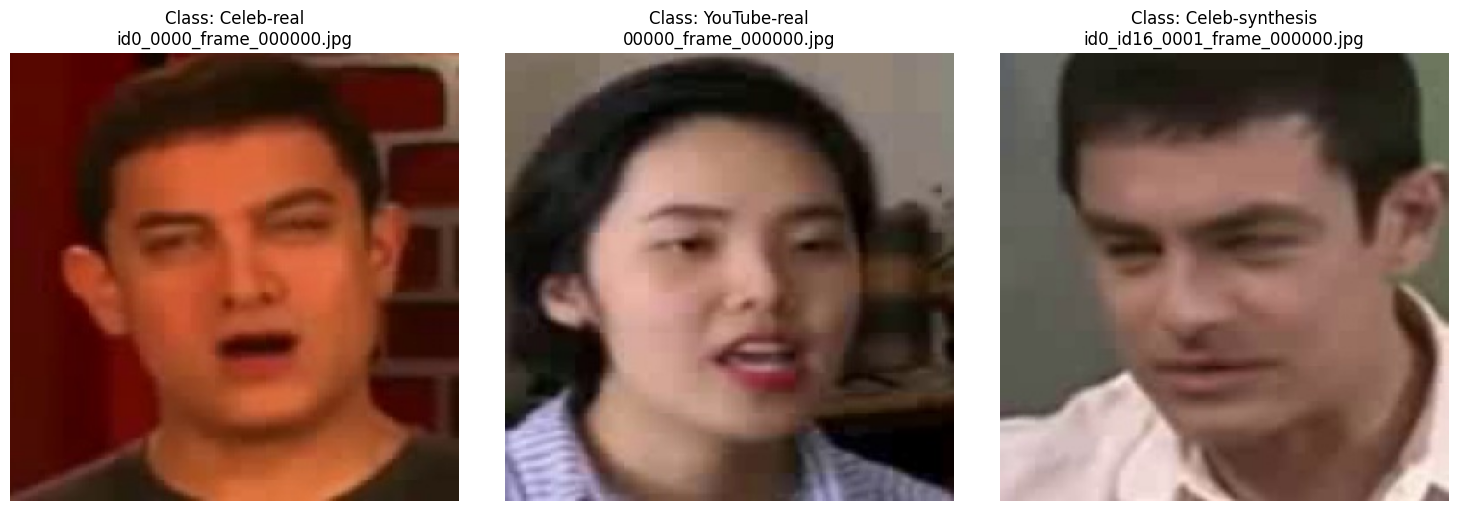

In [ ]:
preview_gcs_images(GCS_PATHS_TO_PREVIEW, gcs)

In [5]:
# Define Parameters and Input
REAL_PATHS = [
    "gs://dlcv_preprocess_pic/Celeb-real/",
    "gs://dlcv_preprocess_pic/YouTube-real/"
]
FAKE_PATHS = [
    "gs://dlcv_preprocess_pic/Celeb-synthesis/"
]

LABEL_REAL = 0
LABEL_FAKE = 1

IMG_SIZE = 224
BATCH_SIZE = 64
RANDOM_SEED = 42

In [6]:
# Create a PyTorch Dataset

class GCSImageDataset(Dataset):
    """
    Custom PyTorch Dataset to load images directly from GCS buckets
    without downloading them locally.
    """
    def __init__(self, file_paths, labels, project, credentials, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.project = project
        self.credentials = credentials
        self.gcs_fs = None
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Fetches the image from GCS, applies transforms, and returns
        the (image, label) pair.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the GCS path and label
        gcs_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            # Each worker process initializes its own GCSFileSystem client
            if self.gcs_fs is None:
                self.gcs_fs = gcsfs.GCSFileSystem(project=self.project, token=self.credentials)

            # Open the file directly from GCS as a byte stream
            with self.gcs_fs.open(gcs_path, 'rb') as f:
                # Read the bytes and open with PIL
                img_bytes = f.read()
                # Use io.BytesIO to treat the bytes as a file
                image = Image.open(io.BytesIO(img_bytes)).convert('RGB')

            # Apply transformations
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading image {gcs_path}: {e}")
            # Return a dummy image and label if loading fails
            return torch.zeros((3, IMG_SIZE, IMG_SIZE)), torch.tensor(0, dtype=torch.long)


In [7]:
class GCSImageDataset(Dataset):
    def __init__(self, file_paths, labels, project, transform=None):
        """
        初始化 Dataset。
        - file_paths: GCS 檔案路徑列表 (例如 'dlcv_preprocess_pic/Celeb-real/img.png')
        - labels: 對應的標籤列表
        - project: 你的 GCP 專案 ID
        - transform: torchvision transforms
        """
        self.file_paths = file_paths
        self.labels = labels
        self.project = project
        self.transform = transform
        self.client = None
        self.bucket_cache = {}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # --- 1. 初始化 GCS Client (每個 worker 只執行一次) ---
        if self.client is None:
            try:
                credentials, _ = google.auth.default()
                self.client = storage.Client(project=self.project, credentials=credentials)
            except Exception as e:
                raise RuntimeError(f"Worker {os.getpid()} failed to initialize GCS client: {e}")

        # --- 2. 解析 GCS 路徑 (*** 這是修正過的地方 ***) ---
        gcs_path = self.file_paths[idx] # 格式為 'bucket/path/to/blob'

        try:
            # gcsfs.glob() 回傳的路徑格式是 'bucket_name/blob_name'
            parts = gcs_path.split('/', 1)
            bucket_name = parts[0] # 例如 'dlcv_preprocess_pic'
            blob_name = parts[1]   # 例如 'Celeb-real/id29...jpg'

            if not bucket_name or not blob_name:
                raise IndexError # 確保兩部分都存在

        except IndexError:
            raise ValueError(f"Invalid GCS path format (expected 'bucket/blob'): {gcs_path}")

        # --- 3. 下載圖片 ---
        try:
            if bucket_name not in self.bucket_cache:
                self.bucket_cache[bucket_name] = self.client.get_bucket(bucket_name)

            bucket = self.bucket_cache[bucket_name]
            blob = bucket.blob(blob_name)
            image_bytes = blob.download_as_bytes()
            image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        except Exception as e:
            print(f"Error loading image {gcs_path}: {e}")
            # 返回一個 placeholder 或跳過
            return self.__getitem__((idx + 1) % len(self))

        # --- 4. 應用 Transforms ---
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [8]:
import pickle

def get_data_loaders(
    real_paths,
    fake_paths,
    gcs_fs,
    batch_size,
    img_size,
    random_seed,
    gcs_bucket_name, # <-- 新增：GCS 儲存桶的名稱
    gcs_save_path    # <-- 新增：要在儲存桶中儲存的路徑 (例如 'my_project/splits')
):
    """
    掃描 GCS, 分割資料, 定義 transforms, 並回傳 dataloaders.

    如果分割清單的 .pkl 檔案已存在, 會直接載入.
    如果不存在, 會建立新的分割, 將其儲存到 GCS, 然後繼續.
    """

    # --- 1. 定義儲存分割清單的 GCS 路徑 ---
    # gcs_fs.open() 需要完整的路徑, 包含 bucket_name
    split_file_name = "dataset_splits.pkl"
    gcs_full_save_path = os.path.join(gcs_bucket_name, gcs_save_path, split_file_name)

    print(f"Checking for existing split file at: {gcs_full_save_path}")

    # --- 2. 檢查檔案是否存在並載入 ---
    if gcs_fs.exists(gcs_full_save_path):
        print("Found existing split file. Loading splits...")
        try:
            with gcs_fs.open(gcs_full_save_path, 'rb') as f:
                dataset_splits = pickle.load(f)

            # 從字典中取回清單
            train_files = dataset_splits['train_files']
            train_labels = dataset_splits['train_labels']
            val_files = dataset_splits['val_files']
            val_labels = dataset_splits['val_labels']
            test_files = dataset_splits['test_files']
            test_labels = dataset_splits['test_labels']

            print(f"Successfully loaded splits (Seed: {dataset_splits.get('random_seed')}).")

        except Exception as e:
            print(f"Error loading {gcs_full_save_path}: {e}")
            print("Will create new splits instead.")
            # 設置 flag 以便進入 else 區塊
            pass # 讓程式掉到下面的 `try...except NameError`

    # --- 3. 如果檔案不存在 (或載入失敗), 則建立新的分割 ---
    try:
        # 檢查 `train_files` 是否在 'if' 區塊中被成功定義
        _ = train_files
        print(f"Train split (loaded): {len(train_files)} images")
        print(f"Valid split (loaded): {len(val_files)} images")
        print(f"Test split  (loaded): {len(test_files)} images")

    except NameError:
        print("No splits loaded. Creating new splits...")

        # --- (以下是你原本的 "Get image paths" 和 "Data Split" 邏輯) ---
        all_files = []
        all_labels = []
        patterns_to_check = ["*.png", "*.jpg", "*.jpeg"]

        # Get REAL image paths
        for path in real_paths:
            path_files = []
            for ext in patterns_to_check:
                path_files.extend(gcs_fs.glob(os.path.join(path, "**", ext)))
            all_files.extend(path_files)
            all_labels.extend([LABEL_REAL] * len(path_files))
            print(f"Found {len(path_files)} REAL images in {path}")

        # Get FAKE image paths
        for path in fake_paths:
            path_files = []
            for ext in patterns_to_check:
                path_files.extend(gcs_fs.glob(os.path.join(path, "**", ext)))
            all_files.extend(path_files)
            all_labels.extend([LABEL_FAKE] * len(path_files))
            print(f"Found {len(path_files)} FAKE images in {path}")

        total_count = len(all_files)
        if total_count == 0:
            raise ValueError("No images found in GCS paths. Check paths and permissions.")

        real_count = all_labels.count(LABEL_REAL)
        fake_count = all_labels.count(LABEL_FAKE)
        print(f"Total images found: {total_count} (Real: {real_count}, Fake: {fake_count})")

        # Data Split
        train_files, temp_files, train_labels, temp_labels = train_test_split(
            all_files, all_labels, test_size=0.3, random_state=random_seed, stratify=all_labels
        )
        val_files, test_files, val_labels, test_labels = train_test_split(
            temp_files, temp_labels, test_size=0.5, random_state=random_seed, stratify=temp_labels
        )

        print(f"Train split (new): {len(train_files)} images")
        print(f"Valid split (new): {len(val_files)} images")
        print(f"Test split  (new): {len(test_files)} images")

        # --- (NEW) 儲存這些清單到 GCS ---
        print(f"Saving new splits to: {gcs_full_save_path}")

        dataset_splits = {
            'train_files': train_files,
            'train_labels': train_labels,
            'val_files': val_files,
            'val_labels': val_labels,
            'test_files': test_files,
            'test_labels': test_labels,
            'random_seed': random_seed
        }

        try:
            # gcsfs 需要 bucket_name/path 來建立目錄
            gcs_dir_path = os.path.join(gcs_bucket_name, gcs_save_path)
            if not gcs_fs.exists(gcs_dir_path):
                print(f"Creating GCS directory: {gcs_dir_path}")
                gcs_fs.mkdir(gcs_dir_path)

            with gcs_fs.open(gcs_full_save_path, 'wb') as f:
                pickle.dump(dataset_splits, f)
            print("Successfully saved splits.")

        except Exception as e:
            print(f"Warning: Failed to save splits to GCS: {e}")
            print("Continuing without saving.")

    # --- 4. (不變) 定義 transforms ---
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        normalize,
    ])
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        normalize,
    ])

    # --- 5. 建立 Datasets 和 DataLoaders (使用新的 GCSImageDataset) ---

    # 獲取你的專案 ID。
    # 確保 `google.auth` 已經 import
    _, project = google.auth.default()
    if project is None:
        raise ValueError("GCP Project ID not found. Please authenticate (e.g., gcloud auth login).")

    # 注意：新的 GCSImageDataset 只需要 project，不再需要 credentials
    train_dataset = GCSImageDataset(
        file_paths=train_files, labels=train_labels, project=project, transform=train_transform
    )
    val_dataset = GCSImageDataset(
        file_paths=val_files, labels=val_labels, project=project, transform=val_test_transform
    )
    test_dataset = GCSImageDataset(
        file_paths=test_files, labels=test_labels, project=project, transform=val_test_transform
    )

    # 關鍵：將 num_workers 改回來！
    # 4 或 8 是一個好的起始點 (取決於你的 CPU 核心數)
    # 如果你用 Colab, 4 通常是安全的
    NUM_WORKERS_TO_USE = 4
    print(f"Using num_workers = {NUM_WORKERS_TO_USE}")

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS_TO_USE, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS_TO_USE, pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS_TO_USE, pin_memory=True
    )

    return train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset

In [9]:
# --- 1. 定義你的 GCS 儲存位置 ---
# 你的 Bucket 名稱 (不含 gs://)
YOUR_BUCKET_NAME = "dlcv_preprocess_pic"

# 你想在 Bucket 內儲存 .pkl 檔案的 "資料夾" 路徑
SPLIT_SAVE_PATH = "dataset_splits"

# --- 2. 呼叫函數 ---
# (假設 gcs, REAL_PATHS, FAKE_PATHS, BATCH_SIZE 等都已經定義好)

train_loader, val_loader, test_loader, _, _, _ = get_data_loaders(
    real_paths=REAL_PATHS,
    fake_paths=FAKE_PATHS,
    gcs_fs=gcs,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    random_seed=RANDOM_SEED,
    gcs_bucket_name=YOUR_BUCKET_NAME,  # <-- 傳入新參數
    gcs_save_path=SPLIT_SAVE_PATH      # <-- 傳入新參數
)

# --- 3. 測試 loader (你的原始碼) ---
print("\nTesting the train_loader...")
try:
    images, labels = next(iter(train_loader))
    print(f"Successfully loaded one batch.")
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
except Exception as e:
    print(f"Error while testing data loader: {e}")

Checking for existing split file at: dlcv_preprocess_pic/dataset_splits/dataset_splits.pkl
Found existing split file. Loading splits...
Successfully loaded splits (Seed: 42).
Train split (loaded): 44506 images
Valid split (loaded): 9537 images
Test split  (loaded): 9537 images
Using num_workers = 4

Testing the train_loader...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Successfully loaded one batch.
Image batch shape: torch.Size([64, 3, 224, 224])
Label batch shape: torch.Size([64])


---

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler # 為了混合精度訓練 (Faster training)
import timm # EfficientNetV2 需要這個庫
from tqdm.notebook import tqdm # 為了顯示進度條

In [11]:
print("Starting data loader process...")
train_loader, val_loader, test_loader, _, _, _ = get_data_loaders(
    real_paths=REAL_PATHS,
    fake_paths=FAKE_PATHS,
    gcs_fs=gcs,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    random_seed=RANDOM_SEED,
    gcs_bucket_name=YOUR_BUCKET_NAME,
    gcs_save_path=SPLIT_SAVE_PATH
)
print("Data loaders are ready!")

Starting data loader process...
Checking for existing split file at: dlcv_preprocess_pic/dataset_splits/dataset_splits.pkl
Found existing split file. Loading splits...
Successfully loaded splits (Seed: 42).
Train split (loaded): 44506 images
Valid split (loaded): 9537 images
Test split  (loaded): 9537 images
Using num_workers = 4
Data loaders are ready!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
# --- 1. 設定設備 (GPU 或 CPU) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 2. 定義模型 ---
model_name = 'tf_efficientnetv2_s'
print(f"Loading EfficientNetV2 model: {model_name}")
model = timm.create_model(model_name, pretrained=True, num_classes=1)
model = model.to(device)

# --- 3. 定義損失函數和優化器 ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 修正 FutureWarning
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else torch.amp.GradScaler('cpu')

# --- 4. 設定訓練參數 (*** GCS 儲存路徑已更新 ***) ---
NUM_EPOCHS = 10
LOCAL_SAVE_PATH = "efficientnetv2_baseline.pth" # 1. Colab 本地儲存的路徑

# *** 2. GCS 儲存路徑 (請確保 YOUR_BUCKET_NAME 已定義) ***
GCS_MODEL_BUCKET = 'dlcv_models'
GCS_MODEL_BLOB_NAME = "efficientnetv2_baseline.pth" # 你想存在 GCS 的資料夾和檔案名稱

print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Best model will be saved locally to: {LOCAL_SAVE_PATH}")
print(f"Best model will ALSO be uploaded to: gs://{GCS_MODEL_BUCKET}/{GCS_MODEL_BLOB_NAME}")

best_val_accuracy = 0.0

Using device: cuda
Loading EfficientNetV2 model: tf_efficientnetv2_s
Training for 10 epochs...
Best model will be saved locally to: efficientnetv2_baseline.pth
Best model will ALSO be uploaded to: gs://dlcv_models/efficientnetv2_baseline.pth


In [22]:
# --- 5. 訓練迴圈 ---
for epoch in range(NUM_EPOCHS):
    # --- 訓練階段 ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)

        optimizer.zero_grad()

        # 修正 FutureWarning
        with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train
    print(f"Epoch {epoch+1} Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    # --- 驗證階段 ---
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            # 驗證時也使用 autocast
            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val
    print(f"Epoch {epoch+1} Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    # --- 儲存最佳模型 (*** GCS 上傳邏輯已新增 ***) ---
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy

        # 1. 先儲存到 Colab 本地
        torch.save(model.state_dict(), LOCAL_SAVE_PATH)
        print(f"Saving best model locally with Val Accuracy: {best_val_accuracy:.4f} to {LOCAL_SAVE_PATH}")

        # 2. (*** 新增 ***) 上傳到 GCS
        try:
            # 初始化 GCS client
            storage_client = storage.Client()
            bucket = storage_client.get_bucket(GCS_MODEL_BUCKET)
            blob = bucket.blob(GCS_MODEL_BLOB_NAME)

            # 從本地檔案上傳
            blob.upload_from_filename(LOCAL_SAVE_PATH)
            print(f"Successfully uploaded best model to gs://{GCS_MODEL_BUCKET}/{GCS_MODEL_BLOB_NAME}")

        except Exception as e:
            print(f"Error: Failed to upload model to GCS: {e}")
            print("Model is saved locally, but NOT in GCS.")

print("Training complete!")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Epoch 1/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 1 Train Loss: 0.5644, Train Accuracy: 0.8831


Epoch 1/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 1 Val Loss: 0.0983, Val Accuracy: 0.9641
Saving best model locally with Val Accuracy: 0.9641 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth


Epoch 2/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 2 Train Loss: 0.0904, Train Accuracy: 0.9655


Epoch 2/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 2 Val Loss: 0.0455, Val Accuracy: 0.9826
Saving best model locally with Val Accuracy: 0.9826 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth


Epoch 3/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 3 Train Loss: 0.0540, Train Accuracy: 0.9792


Epoch 3/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 3 Val Loss: 0.0331, Val Accuracy: 0.9871
Saving best model locally with Val Accuracy: 0.9871 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth


Epoch 4/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 4 Train Loss: 0.0348, Train Accuracy: 0.9870


Epoch 4/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 4 Val Loss: 0.0518, Val Accuracy: 0.9805


Epoch 5/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 5 Train Loss: 0.0302, Train Accuracy: 0.9886


Epoch 5/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 5 Val Loss: 0.0215, Val Accuracy: 0.9918
Saving best model locally with Val Accuracy: 0.9918 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth


Epoch 6/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 6 Train Loss: 0.0240, Train Accuracy: 0.9908


Epoch 6/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 6 Val Loss: 0.0297, Val Accuracy: 0.9886


Epoch 7/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 7 Train Loss: 0.0210, Train Accuracy: 0.9924


Epoch 7/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 7 Val Loss: 0.0217, Val Accuracy: 0.9929
Saving best model locally with Val Accuracy: 0.9929 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth


Epoch 8/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 8 Train Loss: 0.0203, Train Accuracy: 0.9926


Epoch 8/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 8 Val Loss: 0.0270, Val Accuracy: 0.9910


Epoch 9/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 9 Train Loss: 0.0183, Train Accuracy: 0.9932


Epoch 9/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 9 Val Loss: 0.0247, Val Accuracy: 0.9920


Epoch 10/10 [Train]:   0%|          | 0/696 [00:00<?, ?it/s]

Epoch 10 Train Loss: 0.0159, Train Accuracy: 0.9946


Epoch 10/10 [Val]:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 10 Val Loss: 0.0122, Val Accuracy: 0.9954
Saving best model locally with Val Accuracy: 0.9954 to efficientnetv2_baseline.pth
Successfully uploaded best model to gs://dlcv_models/efficientnetv2_baseline.pth
Training complete!
Best Validation Accuracy: 0.9954


In [24]:
# --- 6. 測試階段 (從本地載入) ---
# 訓練剛結束，本地檔案一定存在，所以我們直接從本地載入來測試
print("\n--- Starting Test Evaluation (using local file) ---")
if os.path.exists(LOCAL_SAVE_PATH):
    model.load_state_dict(torch.load(LOCAL_SAVE_PATH))
    model.eval()

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Test Evaluation"):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)

            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            predicted_probs = torch.sigmoid(outputs)
            predicted_classes = (predicted_probs > 0.5).float()

            total_test += labels.size(0)
            correct_test += (predicted_classes == labels).sum().item()
            all_predictions.extend(predicted_classes.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    epoch_test_loss = test_loss / len(test_loader.dataset)
    epoch_test_accuracy = correct_test / total_test
    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.4f}")

    print("\nClassification Report on Test Set:")
    print(classification_report(all_labels, all_predictions, target_names=["Real", "Fake"]))

else:
    print(f"Local model file {LOCAL_SAVE_PATH} not found. Skipping test phase.")

print("Baseline training and evaluation complete!")


--- Starting Test Evaluation (using local file) ---


Test Evaluation:   0%|          | 0/150 [00:00<?, ?it/s]

Test Loss: 0.0122, Test Accuracy: 0.9963

Classification Report on Test Set:
              precision    recall  f1-score   support

        Real       1.00      0.99      0.99      2753
        Fake       1.00      1.00      1.00      6784

    accuracy                           1.00      9537
   macro avg       1.00      0.99      1.00      9537
weighted avg       1.00      1.00      1.00      9537

Baseline training and evaluation complete!


---

In [26]:
!pip install grad-cam matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=f3a8dec7880e8e141514ed980d0fcef763aed21c6ef70765902216908668dcb8
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2 # grad-cam 會用到
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


--- Starting Grad-CAM Explainability Analysis ---
Model set to evaluation mode.
Setting Grad-CAM target to: Conv2d
Getting one image from test_loader...

--- Analysis Finished ---
Model Prediction: FAKE (Raw Logit: 1.0000)
True Label:       FAKE
Displaying Heatmap (Red areas = main focus for the model's decision)


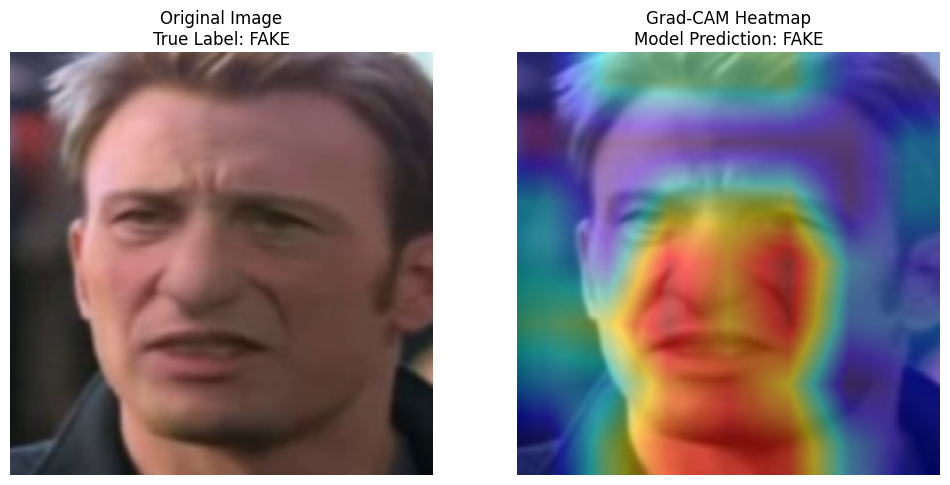

In [30]:
# ======================================================
# 🚀 Grad-CAM (XAI Heatmap) Code (English Version)
# ======================================================

print("\n--- Starting Grad-CAM Explainability Analysis ---")

# --- 1. Ensure model is loaded and in eval mode ---
# (We assume 'model', 'device', 'test_loader' variables are still in memory)
try:
    model.eval()
    print("Model set to evaluation mode.")
except NameError:
    print("Error: 'model' variable is not defined.")
    print("Please ensure you have re-run the code to define and load the model.")
    # Stop here if model doesn't exist
    raise

# --- 2. Define the target layer for Grad-CAM ---
# For timm's 'tf_efficientnetv2_s', 'model.conv_head' is the final conv layer
try:
    target_layers = [model.conv_head]
except AttributeError:
    print("Could not find 'model.conv_head', trying 'model.blocks[-1]'")
    target_layers = [model.blocks[-1]] # Fallback option

print(f"Setting Grad-CAM target to: {target_layers[0].__class__.__name__}")

# --- 3. Create the CAM object ---
# Remove 'use_cuda' parameter as new versions auto-detect the device from the model
cam = GradCAM(model=model,
              target_layers=target_layers)

# --- 4. Define denormalization function (for visualization) ---
# This is standard for ImageNet
def denormalize_image(tensor_img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Ensure tensor is on CPU and transpose [C, H, W] -> [H, W, C]
    img = tensor_img.cpu().numpy().transpose((1, 2, 0))

    img = std * img + mean # Denormalize
    img = np.clip(img, 0, 1) # Clip values to be between 0 and 1
    return img

# --- 5. Get one test image ---
print("Getting one image from test_loader...")
try:
    # Get one batch
    images, labels = next(iter(test_loader))
except Exception as e:
    print(f"Error getting data from test_loader: {e}")
    print("Please ensure test_loader is initialized correctly.")
    raise

# Select the first image from the batch for analysis
input_tensor = images[0].unsqueeze(0).to(device) # [1, 3, H, W]
true_label = labels[0].item()

# Prepare the original RGB image (for overlay)
# denormalize_image needs a [C, H, W] tensor
original_rgb_img = denormalize_image(images[0])

# --- 6. Run prediction and generate CAM ---
# Get model prediction
with torch.no_grad():
    output = model(input_tensor)
    prob = torch.sigmoid(output).item()
    pred_label = 1 if prob > 0.5 else 0

# Define the target for explanation
# Our model has 1 output (index 0)
targets = [ClassifierOutputTarget(0)]

# Generate CAM:
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :] # Get the first (and only) CAM in the batch

# --- 7. Visualize: Overlay CAM on the original image ---
# use_rgb=True because our original image is RGB
visualization = show_cam_on_image(original_rgb_img,
                                  grayscale_cam,
                                  use_rgb=True,
                                  image_weight=0.6) # Opacity of the original image

# --- 8. Display the results ---
pred_text = "FAKE" if pred_label == 1 else "REAL"
true_text = "FAKE" if true_label == 1 else "REAL"

print(f"\n--- Analysis Finished ---")
print(f"Model Prediction: {pred_text} (Raw Logit: {prob:.4f})")
print(f"True Label:       {true_text}")
print("Displaying Heatmap (Red areas = main focus for the model's decision)")

plt.figure(figsize=(12, 6))

# Show original image (denormalized)
plt.subplot(1, 2, 1)
plt.imshow(original_rgb_img)
plt.title(f"Original Image\nTrue Label: {true_text}")
plt.axis('off')

# Show image with Heatmap
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap\nModel Prediction: {pred_text}")
plt.axis('off')

plt.show()

變數 'val_test_transform' 和 'IMG_SIZE' 已經建立。
必要的變數 'model' 和 'device' 已存在。
準備分析...
Running Grad-CAM analysis...

--- 分析完成 ---
檔案: test.png
模型預測: FAKE (信心度: 1.0000)
正在顯示 Heatmap...


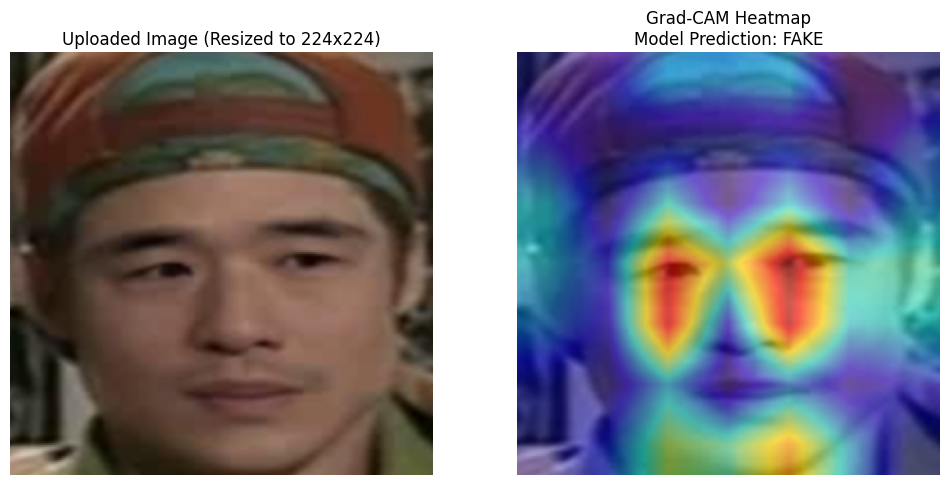

In [46]:
# ======================================================
# 1. 手動定義 'val_test_transform' 和 'IMG_SIZE'
# ======================================================
# (確保這些參數與你訓練時完全一致)

# --- 定義 IMG_SIZE ---
IMG_SIZE = 224

# --- 定義 val_test_transform ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])
print(f"變數 'val_test_transform' 和 'IMG_SIZE' 已經建立。")

# ======================================================
# 🚀 2. 檢查 'model' 和 'device' 是否存在
# ======================================================
try:
    _ = model # 檢查 'model' 是否存在
    _ = device # 檢查 'device' 是否存在
    print("必要的變數 'model' 和 'device' 已存在。")
    print("準備分析...")
except NameError as e:
    print(f"錯誤: 變數 '{e.name}' 未定義。")
    print("---")
    print("請先執行載入模型權重的程式碼 (例如 'load_from_gcs_and_test.py')")
    print("來定義 'model' 和 'device' 變數。")
    raise e # 如果變數不存在，停止執行

# ======================================================
# 🚀 3. 指定圖片路徑並執行分析
# ======================================================

# --- ⚠️ 在這裡指定你要分析的圖片路徑 ---
# (例如: '/content/Test_True.png' 或你上傳的任何檔案)
IMAGE_PATH_TO_ANALYZE = "/content/test.png"

# ----------------------------------------------------

try:
    # --- 檢查檔案是否存在 ---
    if not os.path.exists(IMAGE_PATH_TO_ANALYZE):
        print(f"錯誤: 找不到檔案 '{IMAGE_PATH_TO_ANALYZE}'")
        print("請檢查路徑，或確保你已上傳檔案/從 GCS 複製檔案。")
        print("例如，在 Colab 儲存格中執行: !gsutil cp gs://your-bucket/your-image.png /content/Test_True.png")
        raise FileNotFoundError(f"File not found at: {IMAGE_PATH_TO_ANALYZE}")

    # --- 2. 載入並預處理圖片 ---
    file_name = os.path.basename(IMAGE_PATH_TO_ANALYZE)

    # 從路徑載入 PIL Image
    img_pil = Image.open(IMAGE_PATH_TO_ANALYZE).convert('RGB')

    # 關鍵：應用與你的「測試集」完全相同的轉換
    input_tensor = val_test_transform(img_pil).unsqueeze(0).to(device)

    # --- 3. 準備用於視覺化的原始圖片 ---
    # 調整大小，並轉換為 [0, 1] 範圍的 float numpy array
    original_rgb_img_resized = img_pil.resize((IMG_SIZE, IMG_SIZE))
    original_rgb_img_for_viz = np.array(original_rgb_img_resized) / 255.0

    # --- 4. Grad-CAM 分析 ---
    print("Running Grad-CAM analysis...")
    model.eval()

    # 定義目標層
    try:
        target_layers = [model.conv_head]
    except AttributeError:
        target_layers = [model.blocks[-1]]

    # 建立 CAM 物件
    cam = GradCAM(model=model, target_layers=target_layers)

    # 執行預測
    with torch.no_grad():
        output = model(input_tensor)
        prob = torch.sigmoid(output).item()
        pred_label = 1 if prob > 0.5 else 0 # 1 = FAKE, 0 = REAL

    # 獲取 CAM 熱圖
    targets = [ClassifierOutputTarget(0)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # --- 5. 視覺化 ---
    visualization = show_cam_on_image(original_rgb_img_for_viz,
                                      grayscale_cam,
                                      use_rgb=True,
                                      image_weight=0.6)

    pred_text = "FAKE" if pred_label == 1 else "REAL"

    print(f"\n--- 分析完成 ---")
    print(f"檔案: {file_name}")
    print(f"模型預測: {pred_text} (信心度: {prob:.4f})")
    print("正在顯示 Heatmap...")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_rgb_img_for_viz) # 顯示調整大小後的原始圖片
    plt.title(f"Uploaded Image (Resized to {IMG_SIZE}x{IMG_SIZE})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(f"Grad-CAM Heatmap\nModel Prediction: {pred_text}")
    plt.axis('off')
    plt.show()

except Exception as e:
    print(f"處理影像時發生錯誤: {e}")